# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

### Contents:
- [Background](#Background)
- [Data](#Data)



In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [2]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Average, Input, Activation, Reshape, TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import models, layers, utils
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
pd.options.mode.chained_assignment = None  # default='warn'



**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):** 
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports. 
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* valdation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data import

**import data and get labels**

In [3]:
!unzip drive/My\ Drive/data.zip > /dev/null

In [4]:
train_path = 'data/train/'
valid_path = 'data/valid/'

In [5]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['axial', 'coronal', 'sagittal']
# diagnosis = ['abnormal','meniscus','acl']

In [6]:
def get_data(dataset_type, plane, diagnosis):
    '''this function gets the data for each plane from original dataset'''
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path
        
#     img_path = glob(f'{go}/{plane}/*.npy')
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)
    
    # label_path = f'../data/{dataset_type}-{diagnosis}.csv'
    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, plane_dir, label_data)

**meniscus dataset**

In [7]:
# training data
train_coronal_data, train_coronal_dir, train_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_data, train_axial_dir, train_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_data, train_sagittal_dir, train_men_label = get_data('train', 'sagittal', 'meniscus')

In [8]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_men_label = get_data('valid','coronal','meniscus')
valid_axial_data, valid_axial_dir, valid_men_label = get_data('valid','axial','meniscus')
valid_sagittal_data, valid_sagittal_dir, valid_men_label = get_data('valid','sagittal','meniscus')

In [9]:
train_coronal_data[0]

'0549.npy'

In [10]:
train_coronal_dir

'data/train//coronal'

The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained. 
<br> Unfortunately, when using a pretrained model, one is limited by input_shape. For VGG16, it should be (224, 244, 3), or (3, 224, 224). It should be in 4D tensor with shape (batch_shape, conv_dim1, conv_dim2, channel).

In [11]:
def image_extraction(data, path, new_path): #3 images
    '''this function extracts middle 3 slides of each scan'''
    extract=[]
    new_data=[]
    for i in range(len(data)): 
        img = np.load(os.path.join(path,data[i]))
        middle_idx = int(img.shape[0]/2)
        img = img[(middle_idx - 1) : (middle_idx + 2)]
#         # reshape adapted for model (s x 256 x 256 x 1)
#         img = np.repeat(img[..., np.newaxis], 1, -1)
        img = img.reshape(256,256,3)
        extract.extend(img)
        new_data.append(np.array(extract))        
        extract.clear()
        
#     new_data.shape(1130, 256, 256, 3) for train
    np.save(new_path, np.array(new_data))


**image extraction for training data**

In [12]:
# image extraction for 3 planes
new_path = 'data/train_transform/coronal'
image_extraction(train_coronal_data, train_coronal_dir, new_path)

In [13]:
new_path = 'data/train_transform/axial'
image_extraction(train_axial_data, train_axial_dir, new_path)

In [14]:
new_path = 'data/train_transform/sagittal'
image_extraction(train_sagittal_data, train_sagittal_dir, new_path)

In [15]:
image = np.load('data/train_transform/sagittal.npy')

In [16]:
image[0].shape

(256, 256, 3)

**extraction for validation data**

In [17]:
# image extraction for 3 planes
new_path = 'data/valid_transform/coronal'
image_extraction(valid_coronal_data, valid_coronal_dir, new_path)

In [18]:
new_path = 'data/valid_transform/axial'
image_extraction(valid_axial_data, valid_axial_dir, new_path)

In [19]:
new_path = 'data/valid_transform/sagittal'
image_extraction(valid_sagittal_data, valid_sagittal_dir, new_path)

In [20]:
image = np.load('data/valid_transform/sagittal.npy')
image.shape

(120, 256, 256, 3)

**data generation for meniscus**

In [21]:
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data for each plane from extracted dataset'''
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = 'data/train_transform/'
    else:
        go = 'data/valid_transform/'
        
    plane_dir = f'{go}/{plane}.npy'
    
    data = np.load(plane_dir)
    # label_path = f'../data/{dataset_type}-{diagnosis}.csv'
    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, label_data)
    

In [22]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal', 'meniscus')

# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal', 'meniscus')

In [23]:
def plot_results(model):
    '''this function plots the results of the model'''
    train_loss = model.history['loss']
    test_loss = model.history['val_loss']
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    epoch_labels = model.epoch

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

    axes[0].plot(train_loss, label='Training Loss', color='#185fad')
    axes[0].plot(test_loss, label='Testing Loss', color='orange')

    axes[1].plot(acc, label='Training accuracy', color='blue')
    axes[1].plot(val_acc, label='Testing accuracy', color='red')

    # Set title
    axes[0].title.set_text('Training and Testing Loss by Epoch')
    axes[1].title.set_text('Training and Testing Accuracy by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')
    axes[0].set_ylabel('Binary Crossentropy')
    axes[1].set_ylabel('Binary Crossentropy')
    plt.xticks(epoch_labels, epoch_labels);    
    axes[0].legend(fontsize=18);
    axes[1].legend(fontsize=18);


## Utilising pretrained model

### AlexNet
The below is adapted from [AlexNet](https://neurohive.io/en/popular-networks/alexnet-imagenet-classification-with-deep-convolutional-neural-networks/) which won the 2012 ImageNet LSVRC-2012 competition, and which was also the primary building block for the Stanford group that analysed this data.
<br>
<br> Added 'same' padding, so that output size is the same as input size. This requires the filter window to slip outside input map, hence the need to pad. BatchNormalisation layer was added because it would accelerate the training process, while offering similar classification accuracy. However, I do not know if regularizer was needed, because BatchNormalisation also reported providing a modest form of regularization. But I added the regularizer anyways. l2 (sum of squared weights) were added because it was the most common type (with values in the log scale), and reasonable values of lambda range between 0 and 0.1 (Applied Predictive Modeling, 2013). However, it was reduced to '0.001' and '1e-6' for a slower regularisation. 'sgd' was used so that the learning rate is slow. 

In [326]:
def create_model():
    '''this function creates the model adapted from alexnet'''
    # instantiate
    cnn_model = Sequential()

    # 1st layer
    cnn_model.add(Conv2D(filters = 96,             # number of filters
                         kernel_size = (11, 11),   # height/width of filter
                         activation='relu',        # activation function 
                         input_shape=(256,256,3),  # shape of input (image)
                         strides=(4,4),
                         kernel_regularizer=l2(1e-7),
                         padding='same')) 
    cnn_model.add(BatchNormalization())
    
    # Max pooling
    cnn_model.add(MaxPooling2D(pool_size=(3,3),
                              strides=(2,2),
                              padding='same'))

    # 2nd layer
    cnn_model.add(Conv2D(filters = 256,             
                         kernel_size = (5, 5),   
                         activation='relu',       
                         strides=(1,1),
                         kernel_regularizer=l2(1e-7),
                         padding='same')) 
    cnn_model.add(BatchNormalization())

    # Max pooling
    cnn_model.add(MaxPooling2D(pool_size=(3,3),
                              strides=(2,2),
                              padding='same'))

    # 3rd layer
    cnn_model.add(Conv2D(filters = 384,             
                         kernel_size = (3, 3),   
                         activation='relu',       
                         strides=(1,1),
                         kernel_regularizer=l2(1e-7),
                         padding='same')) 
    cnn_model.add(BatchNormalization())


    # 4th layer
    cnn_model.add(Conv2D(filters = 384,             
                         kernel_size = (3, 3),   
                         activation='relu',       
                         strides=(1,1),
                         kernel_regularizer=l2(1e-7),
                         padding='same')) 
    cnn_model.add(BatchNormalization())

    # 5th layer
    cnn_model.add(Conv2D(filters = 256,             
                         kernel_size = (3, 3),   
                         activation='relu',       
                         strides=(1,1),
                         kernel_regularizer=l2(1e-7),
                         padding='same')) 
    cnn_model.add(BatchNormalization())

    # Max pooling
    cnn_model.add(MaxPooling2D(pool_size=(3,3),
                              strides=(2,2),
                              padding='same'))
    
    # flatten from box to vertical line of nodes!
    cnn_model.add(Flatten())
    
    # 1st fully connected layer
    cnn_model.add(Dense(256, activation='relu'))
    cnn_model.add(BatchNormalization())
    
    # To avoid overfitting!
    cnn_model.add(Dropout(0.2))
    
    # 2nd fully connected layer
    cnn_model.add(Dense(256, activation='relu'))
    cnn_model.add(BatchNormalization())
    
    # To avoid overfitting!
    cnn_model.add(Dropout(0.2))
    
    # Add a final layer with 1 neuron.
    cnn_model.add(Dense(1, activation='sigmoid')) 
    
    sgd = optimizers.SGD(learning_rate=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    
    # Compile model 
    cnn_model.compile(loss='binary_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

    return cnn_model


In [327]:
model = create_model()
model.summary()


Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_320 (Conv2D)          (None, 64, 64, 96)        34944     
_________________________________________________________________
batch_normalization_448 (Bat (None, 64, 64, 96)        384       
_________________________________________________________________
max_pooling2d_192 (MaxPoolin (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_321 (Conv2D)          (None, 32, 32, 256)       614656    
_________________________________________________________________
batch_normalization_449 (Bat (None, 32, 32, 256)       1024      
_________________________________________________________________
max_pooling2d_193 (MaxPoolin (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_322 (Conv2D)          (None, 16, 16, 384)     

In [328]:
for layer in model.layers:
    layer.trainable = True
df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
df.style.applymap(lambda trainable: f'background-color: {"yellow" if trainable else "white"}', subset=['trainable'])

,layer,trainable
0,conv2d_320,True
1,batch_normalization_448,True
2,max_pooling2d_192,True
3,conv2d_321,True
4,batch_normalization_449,True
5,max_pooling2d_193,True
6,conv2d_322,True
7,batch_normalization_450,True
8,conv2d_323,True
9,batch_normalization_451,True


In [329]:
def build_model(model,model_name, num_epochs, train_data, train_labels, validation_data, validation_labels):
    '''this function builds and runs the model'''
    path_dir = '/content/drive/MyDrive' 
    weights_path = f'{path_dir}/{model_name}/alexnet_weights.h5'
    # checkpoint_path = f'{path_dir}/{model_name}/best_model.h5'

    model.save_weights(weights_path)
        
    history = model.fit(x=train_data, y=np.array(train_labels), 
            batch_size=32, 
            validation_data=(validation_data, np.array(validation_labels)),
            epochs=num_epochs, 
            callbacks = [EarlyStopping(patience=1, monitor = 'val_loss', mode = 'min')],                  
            verbose=1)
    
    return model, history

Epoch 1/20
36/36 [==============================] - 6s 117ms/step - loss: 0.9562 - accuracy: 0.4743 - val_loss: 0.8258 - val_accuracy: 0.4417
Epoch 2/20
36/36 [==============================] - 4s 106ms/step - loss: 0.8691 - accuracy: 0.5257 - val_loss: 0.7481 - val_accuracy: 0.4833
Epoch 3/20
36/36 [==============================] - 4s 105ms/step - loss: 0.7871 - accuracy: 0.5743 - val_loss: 0.8179 - val_accuracy: 0.4833


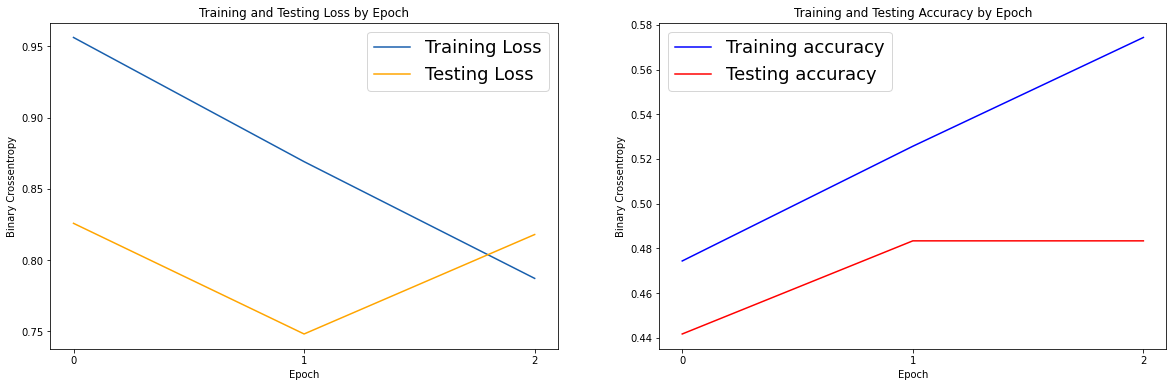

In [330]:
# coronal plane
num_epochs=20

cnn_model=create_model()
cor_men_model, alex_cor_men = build_model(cnn_model,'alex_cor_men', num_epochs, coronal_mensicus, coronal_mensicus_label, coronal_mensicus_val, coronal_mensicus_label_val)

# get/plot accuracy
alex_cor_men_acc=[]
alex_cor_men_acc.append(np.mean(alex_cor_men.history['val_accuracy']))
plot_results(alex_cor_men)

Epoch 1/20
36/36 [==============================] - 6s 114ms/step - loss: 0.9253 - accuracy: 0.4973 - val_loss: 0.7579 - val_accuracy: 0.4750
Epoch 2/20
36/36 [==============================] - 4s 106ms/step - loss: 0.8744 - accuracy: 0.5177 - val_loss: 0.7450 - val_accuracy: 0.4167
Epoch 3/20
36/36 [==============================] - 4s 105ms/step - loss: 0.8090 - accuracy: 0.5469 - val_loss: 0.7140 - val_accuracy: 0.4500
Epoch 4/20
36/36 [==============================] - 4s 106ms/step - loss: 0.7327 - accuracy: 0.6044 - val_loss: 0.7244 - val_accuracy: 0.5083


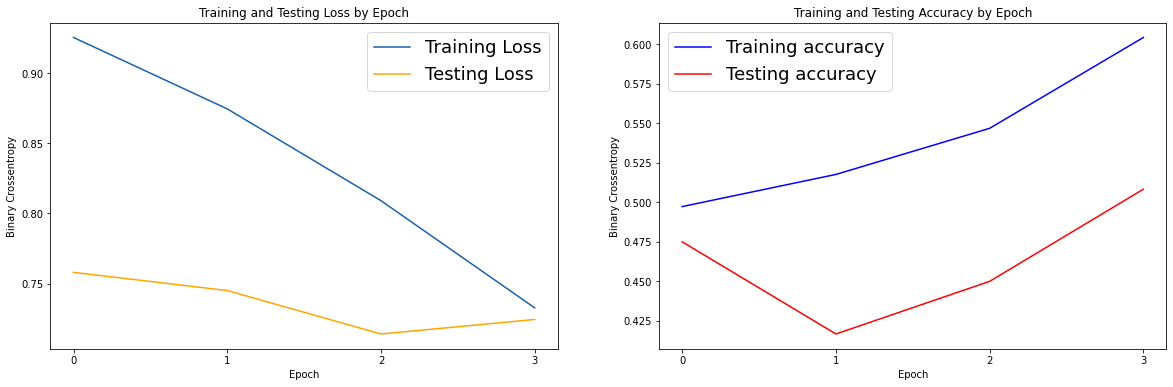

In [331]:
# axial plane
num_epochs=20

cnn_model=create_model()
axl_men_model, alex_axl_men = build_model(cnn_model,'alex_axl_men', num_epochs, axial_mensicus, axial_mensicus_label, axial_mensicus_val, axial_mensicus_label_val)

# get/plot accuracy
alex_axl_men_acc=[]
alex_axl_men_acc.append(np.mean(alex_axl_men.history['val_accuracy']))
plot_results(alex_axl_men)

Epoch 1/20
36/36 [==============================] - 6s 120ms/step - loss: 0.9495 - accuracy: 0.5071 - val_loss: 0.7415 - val_accuracy: 0.4583
Epoch 2/20
36/36 [==============================] - 4s 106ms/step - loss: 0.8415 - accuracy: 0.5248 - val_loss: 0.7466 - val_accuracy: 0.5417


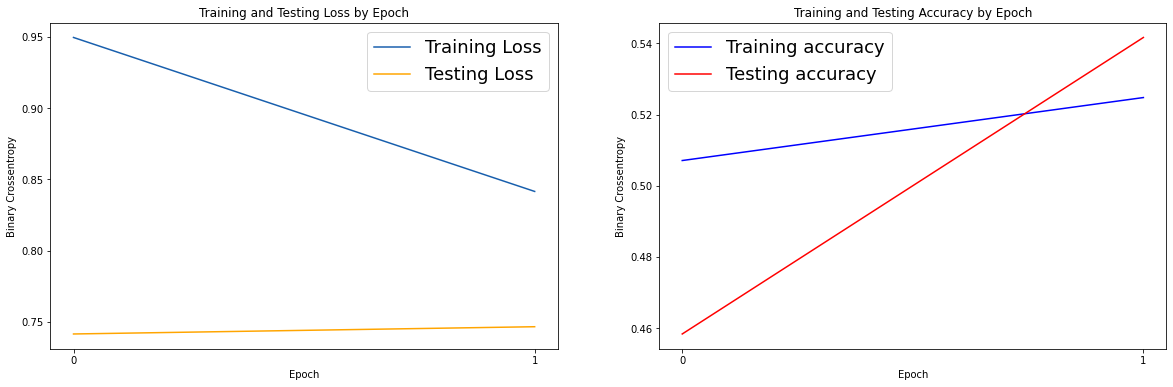

In [332]:
# sagittal plane
num_epochs=20

cnn_model=create_model()
sag_men_model, alex_sag_men = build_model(cnn_model,'alex_sag_men', num_epochs, sagittal_mensicus, sagittal_mensicus_label, sagittal_mensicus_val, sagittal_mensicus_label_val)

# get/plot accuracy
alex_sag_men_acc=[]
alex_sag_men_acc.append(np.mean(alex_sag_men.history['val_accuracy']))
plot_results(alex_sag_men)

**calculate average accuracy**

In [333]:
[alex_cor_men_acc, alex_axl_men_acc, alex_sag_men_acc]

[[0.46944443384806317], [0.4624999910593033], [0.5000000149011612]]

### Evaluate results

In [334]:
cor_men_scores = cor_men_model.evaluate(coronal_mensicus_val, np.array(coronal_mensicus_label_val), verbose=0)
print('Test loss:', cor_men_scores[0]) 
print('Test accuracy:', cor_men_scores[1])

Test loss: 0.8179120421409607
Test accuracy: 0.4833333194255829


In [335]:
cor_pred = cor_men_model.predict(coronal_mensicus_val) 
axl_pred = axl_men_model.predict(axial_mensicus_val) 
sag_pred = sag_men_model.predict(sagittal_mensicus_val) 

In [336]:
pred_men = pd.DataFrame(np.column_stack([cor_pred,axl_pred,sag_pred]),columns=['cor_pred', 'axl_pred', 'sag_pred'])
pred_men['mean'] = pred_men.mean(axis=1)

In [337]:
# since model output is [0,1] using sigmoid activation function
# pred is the probability
# take average probability from all 3 planes
pred_men['mean']

0      0.543030
1      0.579331
2      0.443588
3      0.477346
4      0.428193
         ...   
115    0.510727
116    0.498285
117    0.509104
118    0.712521
119    0.529978
Name: mean, Length: 120, dtype: float32

In [338]:
pred_men['mean'] = pred_men.mean(axis=1)

In [339]:
# if prob<0.5, it is 0.
pred_men['predict'] = pred_men['mean'].map(lambda x: 0 if x<0.5 else 1)

In [340]:
pred_men['predict'].value_counts()

1    70
0    50
Name: predict, dtype: int64

In [341]:
# labels are same for all planes
pred_men['true'] = coronal_mensicus_label_val

In [342]:
pred_men[pred_men['true'] != pred_men['predict']].shape

(66, 6)

In [343]:
pred_men[pred_men['true'] != pred_men['predict']]

,cor_pred,axl_pred,sag_pred,mean,predict,true
0,0.601666,0.612569,0.414855,0.543030,1,0
1,0.713446,0.592245,0.432303,0.579331,1,0
5,0.719761,0.684563,0.436841,0.613722,1,0
6,0.519217,0.506902,0.494590,0.506903,1,0
7,0.842992,0.592714,0.493393,0.643033,1,0
...,...,...,...,...,...,...
104,0.527898,0.571684,0.384465,0.494682,0,1
108,0.635569,0.493477,0.344947,0.491331,0,1
111,0.499961,0.359290,0.227045,0.362099,0,1
112,0.620966,0.471027,0.300427,0.464140,0,1


**export results to csv**

In [344]:
# pred_men.to_csv('../data/alexnet_pred_men_results.csv')
pred_men.to_csv('/content/drive/MyDrive/alexnet_pred_men_results.csv')